# Titanic Survivor Predictions

From Kaggle Competition, this notebook contains a model to compete in *Titanic - Machine Learning from Disaster*, that can be found here: https://www.kaggle.com/competitions/titanic/overview.

## 1. Problem Definition 

Use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

## 2. Data

The data can be downloaded here: https://www.kaggle.com/competitions/titanic/data.

The data has been split into two groups:

* training set (train.csv)
* test set (test.csv)

## 3. Evaluation

Kaggle doesn't provides thersholds for this competition so the aim is to maximize model's **accuracy**.

## 4. Features

Data Dictionary:

1. survival: Survival
    * 0 = No
    * 1 = Yes
2. pclass: Ticket class	
    * 1 = 1st class
    * 2 = 2nd class
    * 3 = 3rd class
3. sex: Sex
4. Age:	Age in years
5. sibsp: Number of siblings / spouses aboard the Titanic	
6. parch: Number of parents / children aboard the Titanic	
7. ticket: Ticket number	
8. fare: Passenger fare	
9. cabin: Cabin number	
10. embarked: Port of Embarkation
    * C = Cherbourg
    * Q = Queenstown
    * S = Southampton

## Explorative Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import the DataFrame
df_train  = pd.read_csv('../input/titanic/train.csv')
df_test   = pd.read_csv('../input/titanic/test.csv')

In [2]:
# Checking the train data head and infos
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [3]:
# Check for missing values in test set
df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Since the Cabin column has the 77% of missing data is convinient to drop it.

Another columns to drop are: 
* Name
* Ticket number

since they are probably not correlated with our predictions.

In [4]:
train = df_train.drop(["Cabin", "Name", "Ticket"], axis = 1)
test = df_test.drop(["Cabin", "Name", "Ticket"], axis = 1)

In [5]:
train

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.0,0,0,13.0000,S
887,888,1,1,female,19.0,0,0,30.0000,S
888,889,0,3,female,NaN,1,2,23.4500,S
889,890,1,1,male,26.0,0,0,30.0000,C


Now proced to EDA using only training set.

Check the distribution of `Pclass` vewing wich of this classes has more possibility to survive.

As we can see, more of the survivros are in the 1st class.

Text(0, 0.5, 'Passenger per Class')

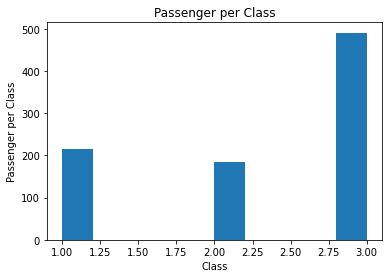

In [6]:
plt.hist(train["Pclass"])
plt.title("Passenger per Class")
plt.xlabel("Class")
plt.ylabel("Passenger per Class")

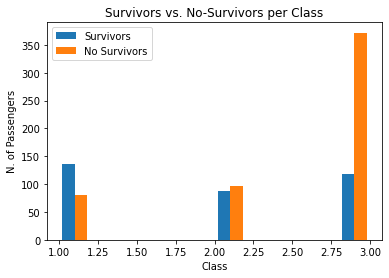

In [7]:
survivors = train["Pclass"][train.Survived == 1]
nosurvivors = train["Pclass"][train.Survived == 0]

plt.hist([survivors, nosurvivors], label=["Survivor", "No Survivor"]);
plt.xlabel("Class")
plt.ylabel("N. of Passengers")
plt.title("Survivors vs. No-Survivors per Class")
plt.legend(["Survivors", "No Survivors"])
             
                        


### Ditribution of ages

Try to visualize the distribution of passengers' age.

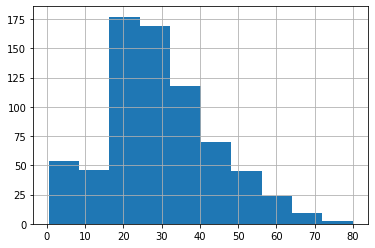

In [8]:
train.Age.hist();

### Fare vs Age

Let's try to visualize the correlation between `Age` and `Fare` with a scatter plot.

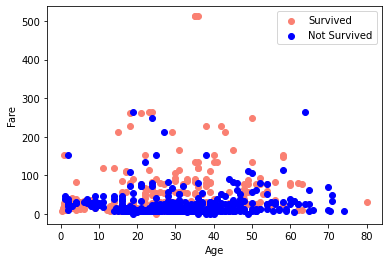

In [9]:
plt.scatter(train.Age[train.Survived == 1],
            train.Fare[train.Survived == 1],
            c = "Salmon")

plt.scatter(train.Age[train.Survived == 0],
            train.Fare[train.Survived == 0],
            c = "Blue")

plt.xlabel("Age")
plt.ylabel("Fare")
plt.legend(["Survived", "Not Survived"])

As it is showed by the plot, the more was the fare the more was the probability to survive.

## Feature Engineering

In this section we look to the features, in particular we will check if there are missing data or categorical variables.

If we have missing data we will fill that, and we will encode categorical variables.

We start by checking test and train infos to find features with missing values and categorical variables.

As we can see, we have some missing values in the two datasets and we have also some categorical variables.

Features with missing values are:
1. Train set:
    * `Age`
    * `Embarked`
2. Test set:
    * `Age`
    * `Fare`

Features with categorical variables (for both test and train sets) are:
* `Sex`
* `Embarked`

### Turn non numerical variables into Pandas Categories
We choose this type of approach because this are categorical variables so encoding this way may be more accurate (ex. missing values in category are coded asv -1), without using sklearn tools that may be provide to  data leak.

In [10]:
for label, content in train.items():
    if pd.api.types.is_string_dtype(content):
        train[label] = content.astype("category").cat.as_ordered()
        
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    int64   
 3   Sex          891 non-null    category
 4   Age          714 non-null    float64 
 5   SibSp        891 non-null    int64   
 6   Parch        891 non-null    int64   
 7   Fare         891 non-null    float64 
 8   Embarked     889 non-null    category
dtypes: category(2), float64(2), int64(5)
memory usage: 50.8 KB


## Filling missing values

**Filling numerical values**

Now we want to fill missing values, but adding some features that give to the machine additional infos, in particular if a value is imputed or not.

In [11]:
for label, content in train.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a column that says if the value is missing or not.
            train[label + "_is_missing"] = pd.isnull(content)
            # Fill numerical values with the median
            train[label] = content.fillna(content.median())

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   PassengerId     891 non-null    int64   
 1   Survived        891 non-null    int64   
 2   Pclass          891 non-null    int64   
 3   Sex             891 non-null    category
 4   Age             891 non-null    float64 
 5   SibSp           891 non-null    int64   
 6   Parch           891 non-null    int64   
 7   Fare            891 non-null    float64 
 8   Embarked        889 non-null    category
 9   Age_is_missing  891 non-null    bool    
dtypes: bool(1), category(2), float64(2), int64(5)
memory usage: 51.7 KB


**Filling and converting categorical variables**

In [12]:
for label, content in train.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add a column if values is missing
        train[label + "_is_missing"] = pd.isnull(content)
        # Change the name of the category with its own code, adding 1
        train[label] = pd.Categorical(content).codes + 1

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PassengerId          891 non-null    int64  
 1   Survived             891 non-null    int64  
 2   Pclass               891 non-null    int64  
 3   Sex                  891 non-null    int8   
 4   Age                  891 non-null    float64
 5   SibSp                891 non-null    int64  
 6   Parch                891 non-null    int64  
 7   Fare                 891 non-null    float64
 8   Embarked             891 non-null    int8   
 9   Age_is_missing       891 non-null    bool   
 10  Sex_is_missing       891 non-null    bool   
 11  Embarked_is_missing  891 non-null    bool   
dtypes: bool(3), float64(2), int64(5), int8(2)
memory usage: 53.2 KB


Now our train data set is filled and all numeric. We can move on choosing a model and train it.

## Modelling

Kaggle doesn't provide a validation set so first of all we split our training data in a validation and a train set, to validate our model.

We'll tray to use these model:
* `LogisticRegression`
* `DecisionTree`
* `RandomForestClassifier`
* `KNeighbours`

First we choose our X (features) and y (labels).

In [13]:
# Creating X and y
X = train.drop("Survived", axis = 1)
y = train["Survived"]


In [14]:
# Setup Random Seed
np.random.seed(42)

# Split the data in training and validation set
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)


# Scaling the features to avoid faliure in models.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_val_std = scaler.transform(X_val)

In [15]:
# Import the model we want
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Define a function to fit and score our model
def fit_and_score(models, X_train, X_val,
                  y_train, y_val):
    # Setup random seed to have repplicable results
    np.random.seed(42)
    # Empty dictionary to memorize our scores
    scores = {}
    # Looping over the methods
    for name, model in models.items():
        # Define the model
        clf = model
        # Fit the model to train data
        clf.fit(X_train, y_train)
        # Scoring our model
        scores[name] = clf.score(X_val, y_val)
    
    return scores

In [16]:
# Creating a model dictionary to test the baseline models.
model_dict = {"Logistic Regression": LogisticRegression(),
              "Decision Tree": DecisionTreeClassifier(),
              "Random Forest": RandomForestClassifier(),
              "KNN": KNeighborsClassifier()}

(<AxesSubplot:>,
           Logistic Regression  Decision Tree  Random Forest       KNN
 accuracy             0.815642       0.776536       0.826816  0.810056)

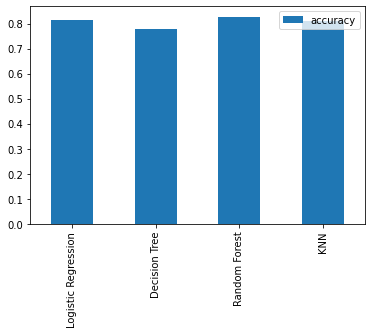

In [17]:
# Scoring the models to choose the one that we want to tune.
model_scores = fit_and_score(models = model_dict,
                             X_train = X_train_std, X_val = X_val_std, 
                             y_train = y_train, y_val = y_val)

# Visualizing the scores of models we choose
models_compare = pd.DataFrame(model_scores, index = ["accuracy"])
models_compare.T.plot.bar(), models_compare

As we can see `RandomForestClassifier()` perform better on this data set and we can pick this model to perform a deeply **Model Driven EDA** and submit predictions to kaggle.

Now we can tray to tune `RandomForest` to improve our scores.

We will use `RandomizedSearchCV` to tune this hyper parameters:
* n_estimators
* max_depth
* min_samples_split
* min_samples_leaf

To standardize features we need to create a pipeline.

In [18]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
my_pipe = Pipeline([("scaler", StandardScaler()),
                     ("clf", RandomForestClassifier())])


# Create a parameters dictionary
param_dict = {"clf__n_estimators": range(50, 1000, 10),
              "clf__max_depth": range(10, 200, 10),
              "clf__min_samples_split": [2, 5, 10],
              "clf__min_samples_leaf": [1, 2, 4]}
# Setup random seed
np.random.seed(42)

# RSCV on RandomForest
rs_rf = RandomizedSearchCV(estimator = my_pipe,
                           param_distributions = param_dict,
                           n_jobs = -1,
                           n_iter = 5,
                           cv = 5,
                           verbose = True)

rs_rf.fit(X_train,y_train)
rs_rf.score(X_val, y_val)


Fitting 5 folds for each of 5 candidates, totalling 25 fits


0.8156424581005587

We don't see emprovement with RSCV. 

Maybe further investigations over data and model is required.

## Making prediction with our trained model

Now we focus on making predictions with our model.

To to this we need to preprocess test data like we did with our test data.

In [19]:
# Changing type to all non numerical values
for label, content in test.items():
    if pd.api.types.is_string_dtype(content):
        test[label] = content.astype("category").cat.as_ordered()
        
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  418 non-null    int64   
 1   Pclass       418 non-null    int64   
 2   Sex          418 non-null    category
 3   Age          332 non-null    float64 
 4   SibSp        418 non-null    int64   
 5   Parch        418 non-null    int64   
 6   Fare         417 non-null    float64 
 7   Embarked     418 non-null    category
dtypes: category(2), float64(2), int64(4)
memory usage: 20.8 KB


In [20]:
for label, content in test.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a column that says if the value is missing or not.
            test[label + "_is_missing"] = pd.isnull(content)
            # Fill numerical values with the median
            test[label] = content.fillna(content.median())

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   PassengerId      418 non-null    int64   
 1   Pclass           418 non-null    int64   
 2   Sex              418 non-null    category
 3   Age              418 non-null    float64 
 4   SibSp            418 non-null    int64   
 5   Parch            418 non-null    int64   
 6   Fare             418 non-null    float64 
 7   Embarked         418 non-null    category
 8   Age_is_missing   418 non-null    bool    
 9   Fare_is_missing  418 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4)
memory usage: 21.6 KB


In [21]:
for label, content in test.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add a column if values is missing
        test[label + "_is_missing"] = pd.isnull(content)
        # Change the name of the category with its own code, adding 1
        test[label] = pd.Categorical(content).codes + 1

test.info(), train.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PassengerId          418 non-null    int64  
 1   Pclass               418 non-null    int64  
 2   Sex                  418 non-null    int8   
 3   Age                  418 non-null    float64
 4   SibSp                418 non-null    int64  
 5   Parch                418 non-null    int64  
 6   Fare                 418 non-null    float64
 7   Embarked             418 non-null    int8   
 8   Age_is_missing       418 non-null    bool   
 9   Fare_is_missing      418 non-null    bool   
 10  Sex_is_missing       418 non-null    bool   
 11  Embarked_is_missing  418 non-null    bool   
dtypes: bool(4), float64(2), int64(4), int8(2)
memory usage: 22.2 KB


(None,
 Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
        'Fare', 'Embarked', 'Age_is_missing', 'Sex_is_missing',
        'Embarked_is_missing'],
       dtype='object'))

In [22]:
y = train["Survived"]
train["Fare_is_missing"] = 0
col = list(test.columns.values)
train = train[col]
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PassengerId          891 non-null    int64  
 1   Pclass               891 non-null    int64  
 2   Sex                  891 non-null    int8   
 3   Age                  891 non-null    float64
 4   SibSp                891 non-null    int64  
 5   Parch                891 non-null    int64  
 6   Fare                 891 non-null    float64
 7   Embarked             891 non-null    int8   
 8   Age_is_missing       891 non-null    bool   
 9   Fare_is_missing      891 non-null    int64  
 10  Sex_is_missing       891 non-null    bool   
 11  Embarked_is_missing  891 non-null    bool   
dtypes: bool(3), float64(2), int64(5), int8(2)
memory usage: 53.2 KB


Now our data set has the same format.

Let's train our `RandomForestClassifier()`, over all train data, and then make prediction.

In [23]:
clf_top = RandomForestClassifier(random_state = 42)
clf_top.fit(train, y)
predictions = clf_top.predict(test)

In [24]:
# Create a submission file for Kaggle competition
pred = {"passengerID": test.PassengerId,
        "Survived": predictions}

pred_df = pd.DataFrame(pred)
submissions = pred_df.to_csv("submissions.csv", index = False)